# Simulate proteome time profiles.
## Start from measured proteome that is already hedged: necessary to enable lactate usage later?

In [1]:
import seaborn as sns
import pandas as pd

sns.plt.rcParams['svg.fonttype'] = 'none'
pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.float_format', lambda x: '%.3g' % x)
%matplotlib inline

In [2]:
PROTOTYPE = True

In [ ]:
from dynamicme.tests.helpme import HelpME
from dynamicme.dynamic import get_cplx_concs

helper = HelpME(prototyping=PROTOTYPE)
solver = helper.solver
me = solver.me

### Already done and saved 
for data in me.complex_data:
    data._complex_id = data.id    
    form_id0 = 'ES_'+data.id.replace('_E_c','')
    try:
        form = me.reactions.get_by_id(form_id0)
        form.id = 'formation_'+ data.id
    except KeyError:
        form = me.reactions.get_by_id('formation_'+data.id)    

me.repair()

from cobrame import mu
from stressme.stressfuncs import update_stoich_expr

me.reactions.Biomass_Ecoli_core_w_GAM.lower_bound = mu
me.reactions.Biomass_Ecoli_core_w_GAM.upper_bound = mu
update_stoich_expr(solver, rxn=me.reactions.Biomass_Ecoli_core_w_GAM)
solver.compiled_expressions = None

In [4]:
%%time
sol_max = solver.bisectmu(verbosity=0, precision=1e-5)

CPU times: user 11.2 s, sys: 83.3 ms, total: 11.3 s
Wall time: 11.2 s


import cPickle
import cloudpickle

with open('/home/laurence/ME/models/tinyME_nostress_v2.pickle','wb') as f:
    cPickle.dump(me,f)
    
with open('/home/laurence/ME/models/solver_tinyME_nostress_v2.pickle','wb') as f:
    cloudpickle.dump(solver,f)

In [5]:
sol_max[0]

0.8456802368164062

In [6]:
me.reactions.Biomass_Ecoli_core_w_GAM.x

0.84568023681640625

In [7]:
from dynamicme.dynamic import DelayedDynamicME

dyme = DelayedDynamicME(solver)
dyme.delay_model.solver.set_realopts('lp', {'Feasibility tol':1e-15,'Optimality tol':1e-15})
dsolver = dyme.delay_model.solver
dme = dsolver.me

/home/laurence/python_modules/dynamicme.git/dynamicme/dynamic.py:1229 UserWarning: Dynamic mRNA not yet implemented!


In [8]:
dme.metabolites.delayed_abundance_PGI_E_c._bound

2.2806862140954783e-05

In [9]:
cplx_concs_max = get_cplx_concs(solver)

In [10]:
mu_me = me.solution.x_dict['biomass_dilution']
print 'mu of ME for growth maximization:', mu_me

mu of ME for growth maximization: 0.845680236816


# FIX THIS and much debugging complete:

In [11]:
dyme.delay_model.update_cplx_concs(cplx_concs_max)

In [12]:
dt = 0.1
dyme.delay_model.update_horizon(dt)

for rxn in dsolver.me.reactions.query('dedt_'):
    rxn.lower_bound = -1000

In [13]:
sol_dyme = dsolver.bisectmu(basis=dsolver.feas_basis, mumax=2, verbosity=0, precision=1e-5)

In [14]:
dme.metabolites.protein_biomass.reactions

frozenset({<SummaryVariable protein_biomass_dilution at 0x7fedbf4dacd0>})

In [15]:
E0 = dme.metabolites.delayed_abundance_PGI_E_c._bound
Et = dme.reactions.abundance_PGI_E_c.x
dedt = dme.reactions.dedt_PGI_E_c.x
print 'E0:\t',E0
print 'E(t):\t',dme.reactions.abundance_PGI_E_c.x
print 'dedt:\t', dedt
print 'dedt*dt:\t', dt*dedt
print 'E0+dedt*dt:\t', E0+dedt*dt
print 'vform:\t', dme.reactions.formation_PGI_E_c.x
print 'mu(t)*E(t):\t', sol_dyme[0]*dme.reactions.abundance_PGI_E_c.x
print 'mu0:\t', sol_max[0]
print 'mu(t):\t', sol_dyme[0]
print 'PGI0:\t', me.reactions.PGI.x
print 'PGI(t):\t', dme.reactions.PGI.x
print 'keff*E_PGI(t):\t', 65.*3600*Et

E0:	2.2806862141e-05
E(t):	2.2806862141e-05
dedt:	-5.81659113221e-20
dedt*dt:	-5.81659113221e-21
E0+dedt*dt:	2.2806862141e-05
vform:	1.92873125764e-05
mu(t)*E(t):	1.92873125764e-05
mu0:	0.845680236816
mu(t):	0.845680236816
PGI0:	5.33680574098
PGI(t):	5.33680574098
keff*E_PGI(t):	5.33680574098


In [16]:
print sol_max[0], '=?=', sol_dyme[0]
assert abs(sol_dyme[0] - sol_max[0]) < 1e-3

0.845680236816 =?= 0.845680236816


In [17]:
print me.reactions.PGI.x, dme.reactions.PGI.x
assert abs(me.reactions.PGI.x - dme.reactions.PGI.x) < 1e-3

5.33680574098 5.33680574098


In [18]:
met = dme.metabolites.delayed_abundance_PGI_E_c
for rxn in met.reactions:
    print '%-25.20s%-35.30s%-35.30s%-25s' % (rxn.x, met.id, rxn.id, rxn.metabolites[met])

print '%-25.20s%-35.30s%-35.30s%-25s' % (met._bound, met.id, '_bound', met._constraint_sense)

2.2806862141e-05         delayed_abundance_PGI_E_c          abundance_PGI_E_c                  1                        
-5.81659113221e-20       delayed_abundance_PGI_E_c          dedt_PGI_E_c                       -0.1                     
2.2806862141e-05         delayed_abundance_PGI_E_c          _bound                             E                        


In [19]:
met = dme.metabolites.enzyme_capacity_PGI_E_c
for rxn in met.reactions:
    print '%-25.20s%-35.30s%-35.30s%-25s' % (rxn.x, met.id, rxn.id, rxn.metabolites[met])

print '%-25.20s%-35.30s%-35.30s%-25s' % (met._bound, met.id, '_bound', met._constraint_sense)

2.2806862141e-05         enzyme_capacity_PGI_E_c            abundance_PGI_E_c                  -1                       
5.33680574098            enzyme_capacity_PGI_E_c            PGI                                4.2735042735e-06         
0                        enzyme_capacity_PGI_E_c            _bound                             L                        


In [20]:
rxn = dme.reactions.PGI
rxn.x * rxn.metabolites[dme.metabolites.enzyme_capacity_PGI_E_c]

2.2806862140954776e-05

In [21]:
dme.reactions.abundance_PGI_E_c.x * 65*3600

5.3368057409834178

# Validate mixed substrate uptake hierarchy--Beg et al. (2007) MSB

In [22]:
import warnings

T = 10   # hours
V = 1.   # L
X0 = 0.00675 / V  # g/L
c0_dict = {'glc__D_e': 0.4,
           'lac__L_e': 0.4,
           'malt_e': 0.4,
           'gal_e': 0.4,
           'glyc_e':0.4,
           'ac_e': 0.0}

### Convert from g/L to mmol
mids_remove = []
for mid,c in c0_dict.iteritems():
    try:        
        met = me.metabolites.get_by_id(mid)    
        c0_dict[met.id] = c / met.formula_weight * 1000
    except KeyError:
        warnings.warn('Model has no metabolite: %s. Will remove it from c0_dict' % mid)
        mids_remove.append(mid)

for mid in mids_remove:
    c0_dict.pop(mid)
        
### Set max uptake rate
LB_EX = -10.
LB_O2 = -20.

lb_dict={}
ub_dict={}

for mid in c0_dict.keys():
    try:
        rxn = dyme.get_exchange_rxn(mid)    
        if rxn.id == 'EX_o2_e':
            lb = LB_O2
        else:
            lb = LB_EX
        rxn.lower_bound = lb
        lb_dict[rxn.id] = lb
    except KeyError:
        warnings.warn('Model has no metabolite: '+ mid)

me.reactions.EX_o2_e.lower_bound = -20.
lb_dict[me.reactions.EX_o2_e.id] = -20.

for k,lb in lb_dict.iteritems():
    rxn = dsolver.me.reactions.get_by_id(k)
    rxn.lower_bound = lb

print c0_dict
print lb_dict

{'ac_e': 0.0, 'glc__D_e': 2.220299442904667}
{'EX_glc_e': -10.0, 'EX_ac_e': -10.0, 'EX_o2_e': -20.0}


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:20 UserWarning: Model has no metabolite: glyc_e. Will remove it from c0_dict
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:20 UserWarning: Model has no metabolite: malt_e. Will remove it from c0_dict
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:20 UserWarning: Model has no metabolite: lac__L_e. Will remove it from c0_dict
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:20 UserWarning: Model has no metabolite: gal_e. Will remove it from c0_dict


In [23]:
solver.set_realopts('lp', {'Feasibility tol':1e-15, 'Optimality tol':1e-15})
from cobrame import MetabolicReaction
fluxes_plot = [r.id for r in dsolver.me.reactions]

In [24]:
cplx_conc_dict0 = cplx_concs_max

In [25]:
%%time
extra_rxns_tracked = list(set(['EX_o2_e'] + fluxes_plot + ['biomass_dilution']))

T = 5
dt = 0.2
H = dt

result = dyme.simulate_batch(
    T,    
    c0_dict,
    X0,
    prec_bs=1e-5,
    ZERO_CONC=0.,
    extra_rxns_tracked=extra_rxns_tracked,
    lb_dict={},
    verbosity=2,
    dt = dt,
    H = H,
    cplx_conc_dict0=cplx_conc_dict0)

Metabolite ac_e depleted.
Metabolite glc__D_e available.
Using default LB=-1000 for EX_glc_e
Computing new uptake rates
Biomass at t=0.2: 0.00789266
Concentrations: {'ac_e': 0.00077461768933657145, 'glc__D_e': 2.205444313190791}
Growth rate: 0.846412658691
Metabolite ac_e available.
Using default LB=-1000 for EX_ac_e
Metabolite glc__D_e available.
Using default LB=-1000 for EX_glc_e
Computing new uptake rates
Biomass at t=0.4: 0.00922958
Concentrations: {'ac_e': 0.0015594828193210702, 'glc__D_e': 2.1879638048301171}
Growth rate: 0.846939086914
Metabolite ac_e available.
Using default LB=-1000 for EX_ac_e
Metabolite glc__D_e available.
Using default LB=-1000 for EX_glc_e
Computing new uptake rates
Biomass at t=0.6: 0.0107937
Concentrations: {'ac_e': 0.0023563444235866465, 'glc__D_e': 2.1674121169690479}
Growth rate: 0.847366333008
Metabolite ac_e available.
Using default LB=-1000 for EX_ac_e
Metabolite glc__D_e available.
Using default LB=-1000 for EX_glc_e
Computing new uptake rates
Bi

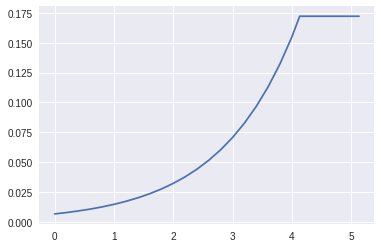

In [26]:
import seaborn as sns
%matplotlib inline

sns.plt.plot(result['time'], result['biomass'])

In [27]:
ex_met_rxn_dict = {m: {'rxn':dyme.get_exchange_rxn(m), 'mw':me.metabolites.get_by_id(m).formula_weight} for m in c0_dict.keys()}
ex_met_rxn_dict

{'ac_e': {'mw': 59.04402,
  'rxn': <MetabolicReaction EX_ac_e at 0x7fedbf5354d0>},
 'glc__D_e': {'mw': 180.15588,
  'rxn': <MetabolicReaction EX_glc_e at 0x7fedbf51e110>}}

In [28]:
import pandas as pd

df_conc = pd.DataFrame(result['concentration'])
### Convert concentrations to g/L
for mid, vals in ex_met_rxn_dict.iteritems():
    df_conc[mid] = df_conc[mid] * vals['mw'] * 0.001

df_time = pd.DataFrame({'time':t, 'biomass':b} for t,b in zip(result['time'], result['biomass']))
df_flux = pd.DataFrame(result['ex_flux'])
df_mu   = pd.DataFrame({'mu':result['growth_rate']})
df_result = pd.concat([df_time, df_conc, df_flux, df_mu], axis=1)

In [29]:
dsplot = pd.melt(df_result, id_vars='time', value_vars=['biomass','ac_e','gal_e','glc__D_e','glyc_e','lac__L_e','malt_e'])
dsplot.time = pd.to_numeric(dsplot.time)
dsplot['category'] = 'Metabolite'
dsplot.loc[ dsplot.variable=='biomass', 'category'] = 'Biomass'

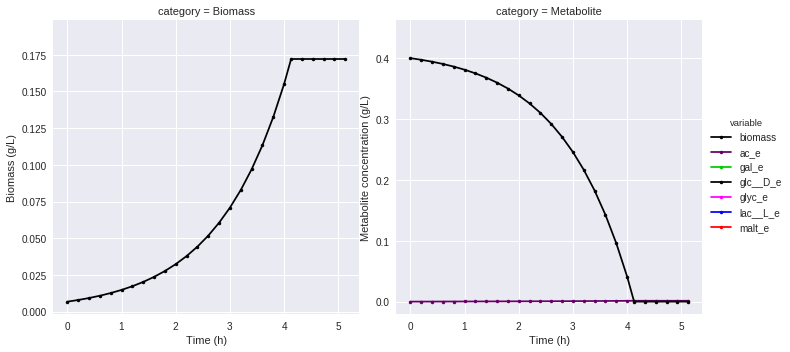

In [30]:
colors = [
'#000000', # biomass
'#660066', # acetate
'#00CC00', #'#00FF00', # galactose
'#000000', # glucose
'#FF00FF', # glycerol
'#0000FF', # lactate
'#FF0000', # maltose
]

colpal = sns.color_palette(colors)
sns.set_palette(colpal)

g = sns.FacetGrid(data=dsplot, hue='variable', col='category', sharey=False, size=5)

g.map(sns.plt.plot, 'time', 'value', linestyle='-', marker='.')
for i,ax in enumerate(g.axes.flat):
    ylim = ax.get_ylim()
    ax.set_ylim((ylim[0],ylim[1]*1.1))
    if i==0:
        ax.set_ylabel('Biomass (g/L)')
    else:
        ax.set_ylabel('Metabolite concentration (g/L)')
g.set_xlabels('Time (h)')
g.add_legend()

In [31]:
if PROTOTYPE:
    complexes_plot = ['IPPMIa_E_c', 'ACKr_reverse_E_c', 'CPLX0-7760_mod_4fe4s','CPLX0-7761_mod_4fe4s']
else:
    complexes_plot = ['3-ISOPROPYLMALISOM-CPLX_mod_4fe4s', 'ACETATEKINA-MONOMER_mod_mg2', 'CPLX0-7659']

In [32]:
fluxes_plot2 = []

for rid in fluxes_plot:
    rxn = dsolver.me.reactions.get_by_id(rid)
    x   = result['rxn_flux'][1][rid]
    try:
        if abs(x) > 10:
            fluxes_plot2.append(rxn.id)
    except:
        pass
        
print len(fluxes_plot2)

9


In [33]:
df_mu = pd.DataFrame([{'time':t, 'variable':'growth_rate', 'value':c, 'category':'growth'} for t,c in zip(result['time'], result['growth_rate'])] )

df_complex = pd.DataFrame([{'time':t, 'complex':c, 'abundance':cdict[c]} 
                           for t,cdict in zip(result['time'], result['complex']) for c in complexes_plot] )

df_mflux = pd.DataFrame([{'time':t, 'rxn':c, 'flux':cdict[c]} 
                           for t,cdict in zip(result['time'], result['rxn_flux']) for c in fluxes_plot2] )

df_complex.loc[:,'category'] = 'complex'
try:
    df_mflux.loc[:,'category'] = 'flux'
except:
    pass

dsplot_all = pd.concat([dsplot,
                        df_mu,
                          df_complex.rename(columns={'complex':'variable', 'abundance':'value'}),
                          df_mflux.rename(columns={'rxn':'variable', 'flux':'value'})])

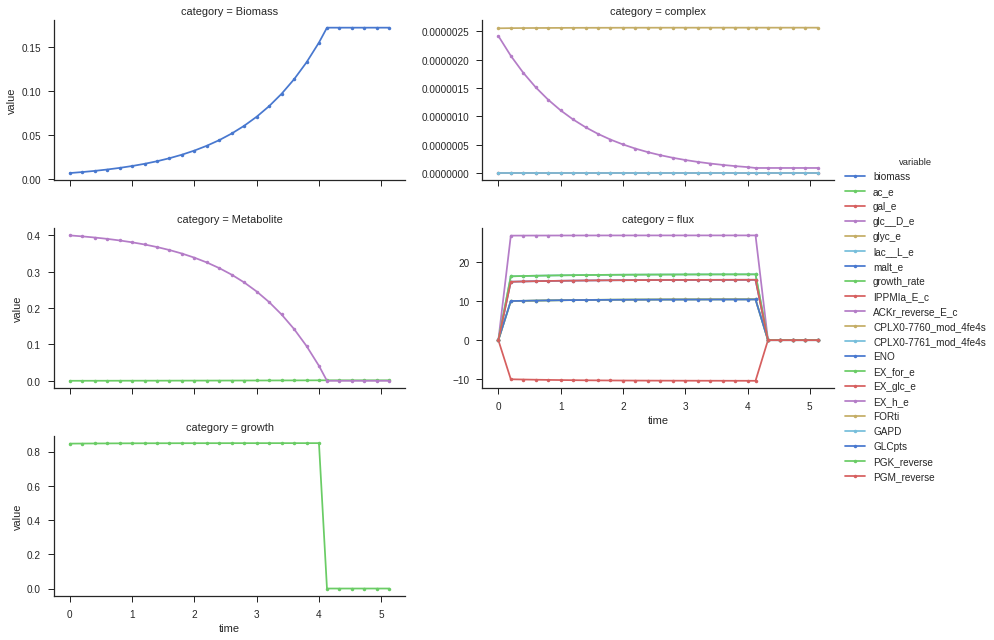

In [34]:
sns.set_style('ticks')
palette = sns.color_palette('muted', len(dsplot_all.variable.unique()))
g = sns.FacetGrid(data=dsplot_all, hue='variable', sharey=False, size=3, col='category', palette=palette,
                  aspect=2, col_wrap=2, col_order=['Biomass','complex','Metabolite','flux','growth'])
g.map(sns.plt.plot, 'time', 'value', linestyle='-', marker='.')
g.add_legend()

In [35]:
me.complex_data.PGI_E_c

<ComplexData PGI_E_c at 0x7fedbfc50350>

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:32 RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python2.7/site-packages/pandas/core/indexing.py:337 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/pandas/core/indexing.py:517 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


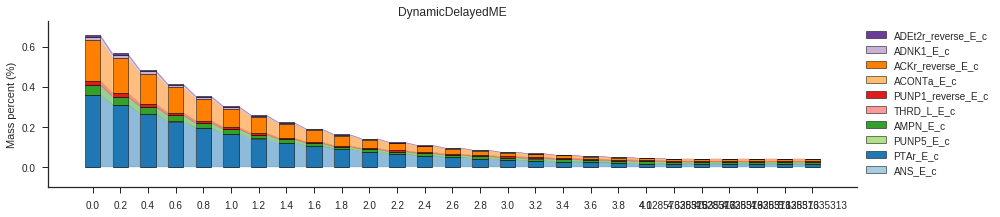

In [36]:
import numpy as np

macro = me.metabolites.macro_mass_constraint_c
rows = []
for data in me.complex_data:
    rxn = data.formation
    cplx = data.complex
    try:
        mass = rxn.metabolites[macro]
        rows.append({'cplx':cplx.id, 'mass':mass})
    except KeyError:
        continue
    
df_mass = pd.DataFrame(rows)

#df_mass = pd.DataFrame([{'cplx':met.id, 'mass':met.mass} for met in me.metabolites if hasattr(met,'mass')])
#df_mass = pd.concat([df_mass, df_ribosome])


df_cplx = pd.DataFrame([{'cplx':k, 'conc':v, 'time':result['time'][i]} for i,r in enumerate(result['complex']) for k,v in r.iteritems()])
df_cplx_mass = pd.merge(df_cplx, df_mass, on='cplx')

times = df_cplx_mass.time.unique()
for t in times:
    dfi = df_cplx_mass[ df_cplx_mass.time==t]
    masses = dfi.conc*dfi.mass
    mtot = masses.sum()
    mfs = masses/mtot
    b = (df_cplx_mass.time==t).values
    df_cplx_mass.loc[b,'mf'] = mfs

df_var = df_cplx_mass.groupby('cplx').mf.apply(lambda x: np.std(x)/np.mean(x)).reset_index()
#df_var = df_cplx_mass.groupby('cplx').mf.mean().reset_index()
N_PLOT = 10
vary_cplxs = df_var.sort_values('mf', ascending=False)['cplx'][0:N_PLOT].tolist()
#vary_cplxs += ['ribosome']
#vary_cplxs += ['ACKr_reverse_E_c']
#vary_cplxs += ['RNAPE-CPLX','RNAP32-CPLX','RNAPS-CPLX','RNAP70-CPLX','RNAP54-CPLX']

df_cplx_mass[ df_cplx_mass.time==0].mf.sum()

from stressme.plot import stacked_bar

dsplot_cplx = df_cplx_mass[ df_cplx_mass.cplx.isin(vary_cplxs)]
dsplot_cplx.loc[:,'group'] = 'DynamicDelayedME'
dsplot_cplx.loc[:,'mperc'] = dsplot_cplx.mf*100
g = stacked_bar('time', 'mperc', dsplot_cplx, 'cplx', 'group', aspect=4, palette_name='Paired')
g.set_ylabels('Mass percent (%)')

In [37]:
df_cplx_mass[ df_cplx_mass.time==1].sort_values('mf', ascending=False)

,conc,cplx,time,mass,mf
5810,0.000021,NADH6_E_c,1.0,627.355,0.220908
11102,0.000044,GLCpts_E_c,1.0,164.881,0.119755
9158,0.000044,PFL_E_c,1.0,148.040,0.106839
13235,0.000065,PGM_reverse_E_c,1.0,65.364,0.070622
11588,0.000065,ENO_E_c,1.0,53.361,0.057654
13127,0.000071,PGK_reverse_E_c,1.0,48.019,0.056646
2273,0.000071,GAPD_E_c,1.0,41.432,0.048876
6755,0.000021,CYTBD_E_c,1.0,116.245,0.041021
113,0.000023,PGI_E_c,1.0,71.324,0.026663
12182,0.000044,FORti_E_c,1.0,36.066,0.026204


In [38]:
result['growth_rate']

[0.8464126586914062,
 0.8469390869140625,
 0.8473663330078125,
 0.84771728515625,
 0.8480072021484375,
 0.8482437133789062,
 0.8484344482421875,
 0.8485946655273438,
 0.848724365234375,
 0.8488235473632812,
 0.8489151000976562,
 0.8489837646484375,
 0.8490371704101562,
 0.8490829467773438,
 0.84912109375,
 0.849151611328125,
 0.84918212890625,
 0.8492050170898438,
 0.8492202758789062,
 0.8492355346679688,
 0.8492431640625,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]